<a href="https://colab.research.google.com/github/kskaran94/WasteClassification/blob/master/Waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries Imported

In [ ]:
from google.colab import files
import json
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, \
Dense, Dropout, Input, add
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
 recall_score, confusion_matrix, precision_recall_curve
from tensorflow.keras.models import save_model, load_model
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import os
import random
import time
import tensorflow

# **Stage 1**
Describe Data

A brief description of the data, where you sourced it, headers of the data. Summary statistics, charts etc...

If you using data from different sources how you might link them.

## Download Data from Kaggle

Dataset is divided into train data (85%) and test data (15%)



Training data - 22564 images
 Test data - 2513 images of recyclable and organic objects.

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

token = {"username":"****","key":"******"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d techsash/waste-classification-data

cp: cannot stat 'kaggle.json': No such file or directory
100% 426M/427M [00:03<00:00, 118MB/s]
100% 427M/427M [00:03<00:00, 114MB/s]


In [ ]:
!unzip waste-classification-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

# **Stage 2**
Justification for the property that you would like the model to predict.

## Dataset File Structure

The first step after downloading the data would be to look at the data set file structure.

In [ ]:
!ls DATASET/

TEST  TRAIN


We, see that the dataset has pre-defined train and test splits. We are missing a validation and before any modling or configuration, the task would be to construct a validation set from the existing train test. At this point, test set is untouched.

In [ ]:
!ls DATASET/TRAIN/

O  R


## Objective

Build a image classifier to correctly identify Recyclable and Organic waste.

### Copying files

Function copies given file_names from source to destination using shutil

In [ ]:
def copyfiles(file_names, dest, src_path):
    for file in file_names:
        full_file_name = os.path.join(src_path, file)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dest)

# **Stage 3**

Cleaning the data, linking datasets etc..


### Train Validation Split

Function takes a path of a directory and percentage of train to split the data into train and validation. Sklearn's train_test_split works only with dataframes /arrays. This function is written for  directory-file structure.

In [ ]:
def train_val_test_split(path, perc):
    train_string  = 'train/'
    val_string  = 'val/'
    dest_path = '/content/'
    try:
        os.mkdir(dest_path + train_string)
        os.mkdir(dest_path + val_string)
    except:
        shutil.rmtree(dest_path + train_string)
        shutil.rmtree(dest_path + val_string)
        os.mkdir(dest_path + train_string)
        os.mkdir(dest_path + val_string)

    sub_direc = os.listdir(path=path)

    for sub in sub_direc:
      if sub in ['O','R']:
        try:
            shutil.rmtree(dest_path + train_string + sub)
            shutil.rmtree(dest_path + val_string + sub)
        except:
            os.makedirs(dest_path+train_string+sub)
            os.makedirs(dest_path+val_string+sub)
        src_path = path + sub
        filenames = os.listdir(src_path)
        filenames.sort()
        # make sure that the filenames have a fixed order before shuffling
        random.shuffle(filenames)
        # shuffles the ordering of filenames (deterministic given the chosen seed)

        split_1 = int(perc * len(filenames))
        train_filenames = filenames[:split_1]
        val_filenames = filenames[split_1:]

        copyfiles(train_filenames, dest_path+train_string+sub, src_path)
        ## train set path for all classes
        copyfiles(val_filenames, dest_path+val_string+sub, src_path)
        ## validation set path for all classes


In [ ]:
train_val_test_split('DATASET/TRAIN/', 0.8)

### Predict from generator

In [ ]:
def predict_from_generator(generator, model):
    pred = model.predict_generator(generator)
    predicted_class_indices = np.argmax(pred, axis = -1)
    classes = generator.classes[generator.index_array]
    return predicted_class_indices, classes

## Data Preparation and Configuration

Preparing the data for the model is an important task. In case of images, standard preparation techniques include rescaling, resizing and data augmentation (if needed). Keras provides ImageDataGenerator class for data preparation. We will be defining three different ImageDataGenerators for train, validation and test sets respectively.

Rescaling of images is defined within the ImageDataGenerator.

In [ ]:
batch_size=64

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In this case batch size is a paramter which can be tuned and the evaluation metric may also vary with different batch_size.

The Image data generator is used for returning configured images using the flow functions. We will be using the flow_from_directory to configure the images. There are other ways which can found here https://keras.io/preprocessing/image/

In this code block, the paramter that can be tuned is the target size of the image.

In [ ]:
train_generator = train_datagen.flow_from_directory(
            'train/',  # this is the target directory
            target_size=(150, 150),  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical',shuffle=True)

val_generator = val_datagen.flow_from_directory(
        'val/',  # this is the target directory
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)


test_generator = test_datagen.flow_from_directory(
        'DATASET/TEST/',  # this is the target directory
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

Found 18051 images belonging to 2 classes.
Found 4513 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


# Baseline

## Model Defintion and Compilation

In [ ]:
num_classes = 2
input_shape = (150, 150, 3)

cnn_small_bn = Sequential([
    Conv2D(8, kernel_size = (3,3), input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(8, kernel_size = (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(num_classes, activation='softmax'),
                 ])

cnn_small_bn.summary()

cnn_small_bn.compile("adam", "categorical_crossentropy",
                     metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10368)             0         
                                                                 
 dense (Dense)               (None, 2)                 2

# **Stage 4**
Choose and train Estimator.

## Model Training

In [ ]:
train_size = train_generator.samples
val_size = val_generator.samples


history_cnn = cnn_small_bn.fit_generator(
    train_generator,
    steps_per_epoch=train_size/batch_size,
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=val_size/ batch_size)


<ipython-input-15-b73c74de3a1f>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_cnn = cnn_small_bn.fit_generator(


Epoch 1/50
282/282 [==============================] - 47s 128ms/step - loss: 0.4516 - accuracy: 0.7990 - val_loss: 0.4111 - val_accuracy: 0.8205
Epoch 2/50
282/282 [==============================] - 34s 119ms/step - loss: 0.3947 - accuracy: 0.8301 - val_loss: 0.3969 - val_accuracy: 0.8331
Epoch 3/50
282/282 [==============================] - 35s 124ms/step - loss: 0.3618 - accuracy: 0.8465 - val_loss: 0.3871 - val_accuracy: 0.8427
Epoch 4/50
282/282 [==============================] - 38s 136ms/step - loss: 0.3497 - accuracy: 0.8528 - val_loss: 0.3732 - val_accuracy: 0.8422
Epoch 5/50
282/282 [==============================] - 35s 122ms/step - loss: 0.3328 - accuracy: 0.8610 - val_loss: 0.4008 - val_accuracy: 0.8354
Epoch 6/50
282/282 [==============================] - 34s 121ms/step - loss: 0.3133 - accuracy: 0.8698 - val_loss: 0.3660 - val_accuracy: 0.8469
Epoch 7/50
282/282 [==============================] - 35s 123ms/step - loss: 0.2998 - accuracy: 0.8782 - val_loss: 0.3741 - val_ac

<Axes: >

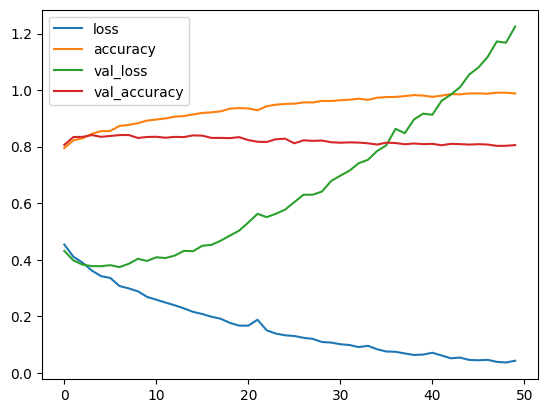

In [ ]:
pd.DataFrame(history_cnn.history).plot()

<ipython-input-9-262edac64455>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(generator)


The recall is  0.798
The precision is 0.7710144927536232


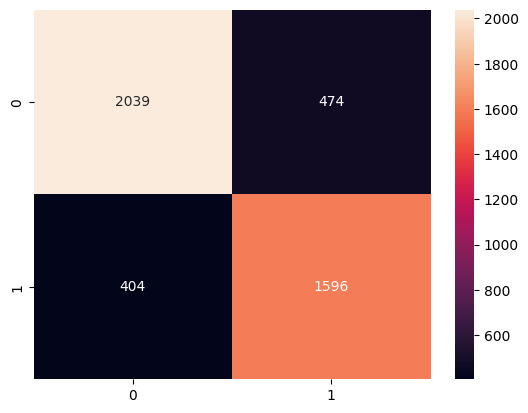

In [ ]:
val_pred, val_classes = predict_from_generator(val_generator, cnn_small_bn)


cnf_matrix_val = confusion_matrix(val_classes, val_pred)

fig1 = sns.heatmap(cnf_matrix_val, annot=True, fmt="d")


print("The recall is ", recall_score(val_classes, val_pred))

print("The precision is", precision_score(val_classes, val_pred))

<ipython-input-9-262edac64455>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(generator)


The recall is  0.7769784172661871
The precision is 0.8588469184890656


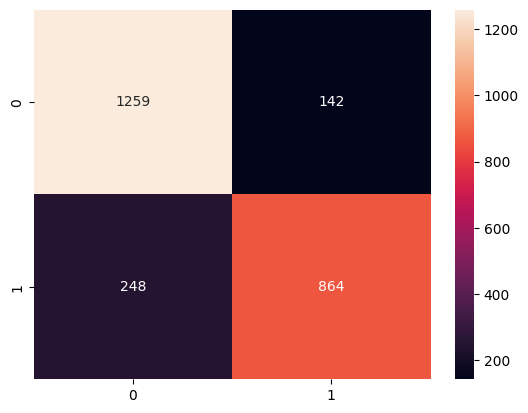

In [ ]:
test_pred, test_classes = predict_from_generator(test_generator, cnn_small_bn)


cnf_matrix_test = confusion_matrix(test_classes, test_pred)

fig1 = sns.heatmap(cnf_matrix_test, annot=True, fmt="d")


print("The recall is ", recall_score(test_classes, test_pred))

print("The precision is", precision_score(test_classes, test_pred))

# **Stage 5**
Evaluate your model and revisit 4...repeat..

# Improving Baseline (v1)

In [ ]:
num_classes = 2
input_shape = (150, 150, 3)


cnn_small_bn_v2 = Sequential([

    Conv2D(16, kernel_size = (4,4), input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(16),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
                 ])

cnn_small_bn_v2.summary()

cnn_small_bn_v2.compile("adam", "categorical_crossentropy",
                     metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 147, 147, 16)      784       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 73, 73, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 70, 70, 16)        4112      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 35, 35, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        4112      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 16)      

In [ ]:
history_cnn = cnn_small_bn_v2.fit_generator(
    train_generator,
    steps_per_epoch=train_size/batch_size,
    epochs=20,
    verbose=1,
    validation_data=val_generator,
    validation_steps=val_size/ batch_size)


Epoch 1/20


<ipython-input-18-be5b0c04cd89>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_cnn = cnn_small_bn_v2.fit_generator(


282/282 [==============================] - 41s 135ms/step - loss: 0.4614 - accuracy: 0.7960 - val_loss: 0.4287 - val_accuracy: 0.8072
Epoch 2/20
282/282 [==============================] - 40s 142ms/step - loss: 0.4044 - accuracy: 0.8301 - val_loss: 0.4161 - val_accuracy: 0.8181
Epoch 3/20
282/282 [==============================] - 38s 133ms/step - loss: 0.3741 - accuracy: 0.8476 - val_loss: 0.3574 - val_accuracy: 0.8442
Epoch 4/20
282/282 [==============================] - 37s 130ms/step - loss: 0.3483 - accuracy: 0.8582 - val_loss: 0.3301 - val_accuracy: 0.8631
Epoch 5/20
282/282 [==============================] - 40s 141ms/step - loss: 0.3426 - accuracy: 0.8642 - val_loss: 0.3293 - val_accuracy: 0.8602
Epoch 6/20
282/282 [==============================] - 38s 133ms/step - loss: 0.3261 - accuracy: 0.8693 - val_loss: 0.4192 - val_accuracy: 0.8165
Epoch 7/20
282/282 [==============================] - 36s 129ms/step - loss: 0.3179 - accuracy: 0.8751 - val_loss: 0.3493 - val_accuracy: 0.8

<Axes: >

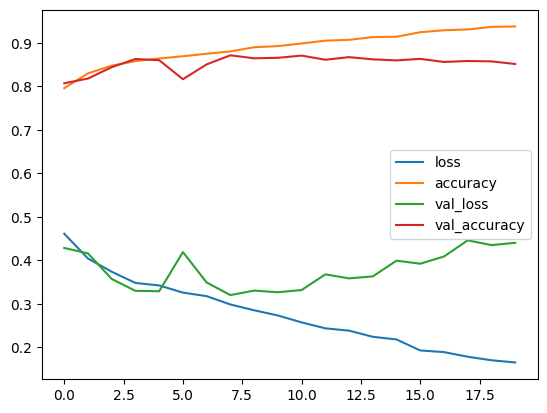

In [ ]:
pd.DataFrame(history_cnn.history).plot()

<ipython-input-9-262edac64455>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(generator)


The recall is  0.842
The precision is 0.8263002944062807


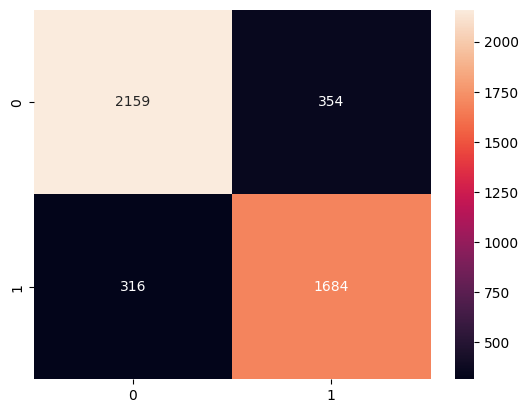

In [ ]:

val_pred, val_classes = predict_from_generator(val_generator, cnn_small_bn_v2)


cnf_matrix_val = confusion_matrix(val_classes, val_pred)

fig1 = sns.heatmap(cnf_matrix_val, annot=True, fmt="d")

print("The recall is ", recall_score(val_classes, val_pred))

print("The precision is", precision_score(val_classes, val_pred))

<ipython-input-9-262edac64455>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(generator)


The recall is  0.8282374100719424
The precision is 0.8898550724637682


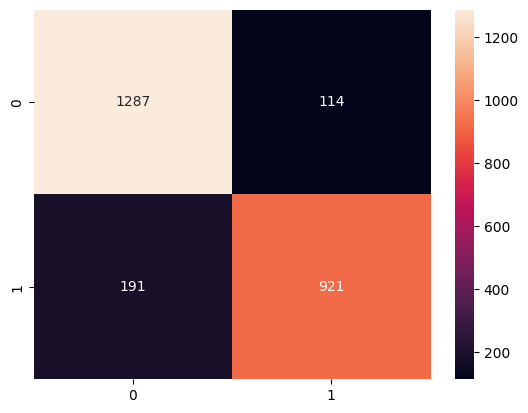

In [ ]:
test_pred, test_classes = predict_from_generator(test_generator, cnn_small_bn_v2)


cnf_matrix_test = confusion_matrix(test_classes, test_pred)

fig1 = sns.heatmap(cnf_matrix_test, annot=True, fmt="d")


print("The recall is ", recall_score(test_classes, test_pred))

print("The precision is", precision_score(test_classes, test_pred))

## Improving Baseline (v2)

In [ ]:
num_classes = 2
input_shape = (150, 150, 3)


cnn_small_bn_v3 = Sequential([

    Conv2D(16, kernel_size = (4,4), input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(16),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
                 ])

cnn_small_bn_v3.summary()

cnn_small_bn_v3.compile("adam", "categorical_crossentropy",
                     metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 147, 147, 16)      784       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 73, 73, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 70, 70, 16)        4112      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 35, 35, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        4112      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 16)      

In [ ]:
history_cnn = cnn_small_bn_v3.fit_generator(
    train_generator,
    steps_per_epoch=train_size/batch_size,
    epochs=20,
    verbose=1,
    validation_data=val_generator,
    validation_steps=val_size/ batch_size)


Epoch 1/20


<ipython-input-16-4f95b807efcc>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_cnn = cnn_small_bn_v3.fit_generator(


282/282 [==============================] - 40s 130ms/step - loss: 0.4768 - accuracy: 0.7846 - val_loss: 0.4202 - val_accuracy: 0.8176
Epoch 2/20
282/282 [==============================] - 41s 146ms/step - loss: 0.4083 - accuracy: 0.8279 - val_loss: 0.3641 - val_accuracy: 0.8484
Epoch 3/20
282/282 [==============================] - 41s 145ms/step - loss: 0.3785 - accuracy: 0.8439 - val_loss: 0.3375 - val_accuracy: 0.8604
Epoch 4/20
282/282 [==============================] - 37s 131ms/step - loss: 0.3570 - accuracy: 0.8552 - val_loss: 0.3439 - val_accuracy: 0.8595
Epoch 5/20
282/282 [==============================] - 36s 129ms/step - loss: 0.3407 - accuracy: 0.8629 - val_loss: 0.3201 - val_accuracy: 0.8717
Epoch 6/20
282/282 [==============================] - 35s 124ms/step - loss: 0.3526 - accuracy: 0.8591 - val_loss: 0.3610 - val_accuracy: 0.8533
Epoch 7/20
282/282 [==============================] - 35s 125ms/step - loss: 0.3362 - accuracy: 0.8640 - val_loss: 0.3155 - val_accuracy: 0.8

<Axes: >

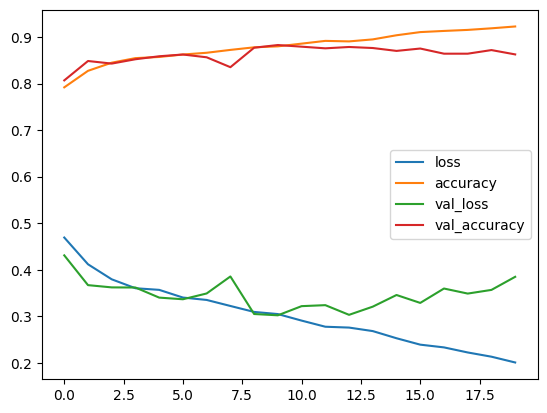

In [ ]:
pd.DataFrame(history_cnn.history).plot()

<ipython-input-9-262edac64455>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(generator)


The recall is  0.8425
The precision is 0.8471593765711413


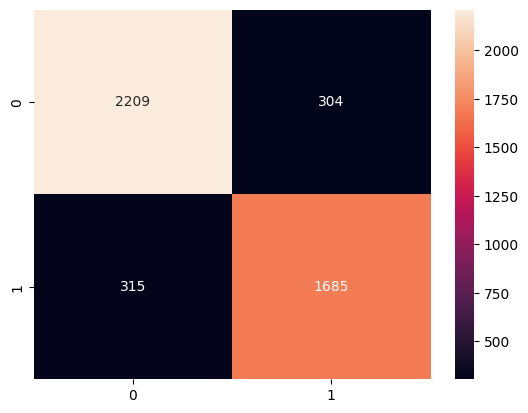

In [ ]:

val_pred, val_classes = predict_from_generator(val_generator, cnn_small_bn_v3)


cnf_matrix_val = confusion_matrix(val_classes, val_pred)

fig1 = sns.heatmap(cnf_matrix_val, annot=True, fmt="d")

print("The recall is ", recall_score(val_classes, val_pred))

print("The precision is", precision_score(val_classes, val_pred))

In [ ]:
test_pred, test_classes = predict_from_generator(test_generator, cnn_small_bn_v3)


cnf_matrix_test = confusion_matrix(test_classes, test_pred)

fig1 = sns.heatmap(cnf_matrix_test, annot=True, fmt="d")


print("The recall is ", recall_score(test_classes, test_pred))

print("The precision is", precision_score(test_classes, test_pred))

NameError: ignored

In [ ]:
# datagen = ImageDataGenerator(
# rotation_range=40,
# width_shift_range=0.2,
# height_shift_range=0.2,
# shear_range=0.2,
# zoom_range=0.2,
# horizontal_flip=True)

# **Stage 6**
***Present results and Conclusions***


# Save the Model

In [ ]:
cnn_small_bn_v3.save(os.path.join('models','WasteIdentifier.h5'))

NameError: ignored

# Load the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
new_model = load_model(os.path.join('models','WasteIdentifier.h5'))

In [ ]:
new_model

In [ ]:
import cv2

<function matplotlib.pyplot.show(close=None, block=None)>

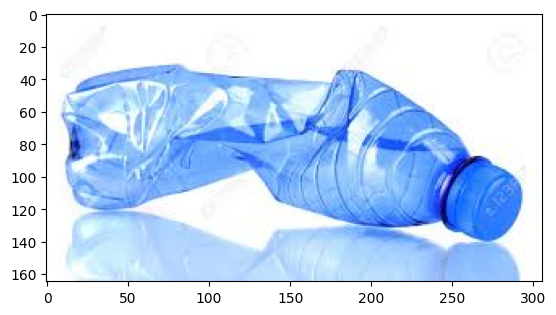

In [ ]:
img=cv2.imread("R_21.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

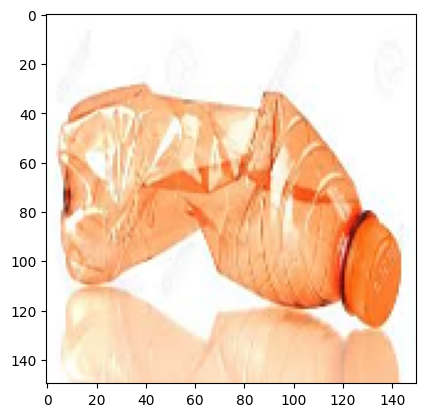

In [ ]:
resized_image = tensorflow.image.resize(img, (150,150))
plt.imshow(resized_image.numpy().astype(int))
plt.show

In [ ]:
np.expand_dims(resized_image, 0)

array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        ...,

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 254., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 254., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
       

In [ ]:
np.expand_dims(resized_image, 0).shape

(1, 150, 150, 3)

# Prediction and Results

In [ ]:
result_of_new_model = new_model.predict(np.expand_dims(resized_image/255,0))

1/1 [==============================] - 0s 20ms/step


In [ ]:
result_of_new_model

array([[0.997053  , 0.00294691]], dtype=float32)

In [ ]:
result_of_new_model[0,0]

0.997053

In [ ]:
result_of_new_model = result_of_new_model[0,0]

In [ ]:
if result_of_new_model > 0.5:
  print(f'Predicted class is Recycble Waste')
else:
  print(f'Predicted class is Organic Waste')

Predicted class is Recycble Waste


<function matplotlib.pyplot.show(close=None, block=None)>

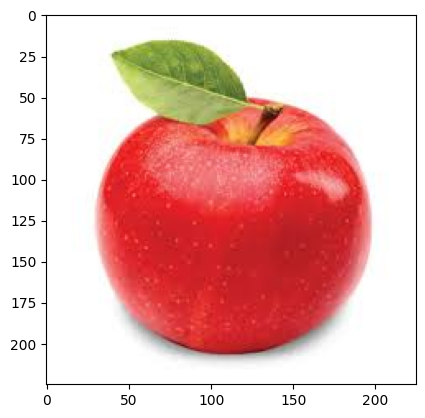

In [ ]:
img2=cv2.imread("O_4.jpg")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

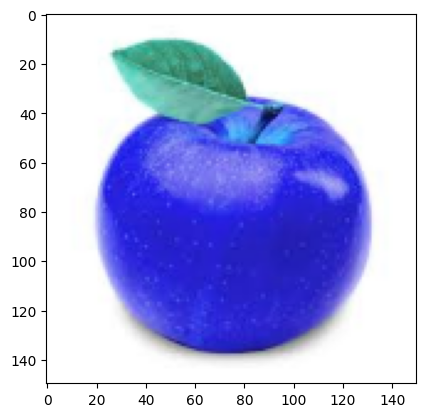

In [ ]:
resized_image2 = tensorflow.image.resize(img2, (150,150))
plt.imshow(resized_image2.numpy().astype(int))
plt.show

In [ ]:
np.expand_dims(resized_image2, 0)

array([[[[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        ...,

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]],

        [[255., 255., 255.],
       

In [ ]:
np.expand_dims(resized_image2, 0).shape

(1, 150, 150, 3)

In [ ]:
result_of_new_model2 = new_model.predict(np.expand_dims(resized_image2/255,0))

1/1 [==============================] - 0s 19ms/step


In [ ]:
result_of_new_model2

array([[4.3446978e-04, 9.9956554e-01]], dtype=float32)

In [ ]:
result_of_new_model2[0,0]

0.00043446978

In [ ]:
result_of_new_model2 = result_of_new_model2[0,0]

In [ ]:
if result_of_new_model2 > 0.5:
  print(f'Predicted class is Recycble Waste')
else:
  print(f'Predicted class is Organic Waste')

Predicted class is Organic Waste
